ROI Classification
--
Info about classes:  
This scripts includes a pretrained model to classify ROIs as one of the following categories:
- **Label 0:** Neuron + In-plane ("Great")
- **Label 1:** Neuron + Semi-in-plane ("Okay")
- **Label 4:** Neuron + Out of plane ("Poor")
- **Label 5:** Dendrite

(*note that during the manual labeling, 0-5 is actually 1-6*)  <br>
(*label 2 is for weird blobs and shadows of neurons*)  <br>
(*label 3 is empty on purpose*)  <br>
___

Info about neural network:  
The network is trained on ~4700 ROIs from one FOV  
(mouse 6.28 , recorded on 20200903)  
- **Net_ROIClassifier_20200917.pth** state_dict file must be in path
- This script is specifically for the above .pth parameters file. Changes to the architecture cannot be made here.
___

Input data requirements:
---
- 36x36 images
- dim1: image number
- dim 2,3: y,x
- should be normalized between 0-1  


- **There are cell blocks to use the 'stat.npy' output from Suite2p and convert to the required format**


- Full FOV size (in pixels) should be known. Default=512x1024
___



In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
# import sys
# import copy

import numpy as np

import scipy
import scipy.signal
from scipy.io import savemat

import matplotlib.pyplot as plt


import pathlib

In [3]:
## lOAD & PREPROCESS stat.npy file
## outputs: 'images' (input into CNN)

# dir_load = '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\round 4 experiments\\mouse 6.28\\20200815\\suite2p\\plane0\\'

# PATH_absolute = pathlib.Path('.').absolute()
# PATH_load_dir_statFile = f'{PATH_absolute}/'
# PATH_load_dir_statFile = '/media/rich/Home_Linux_partition/GoogleDrive_ocaml_cache/Research/Sabatini Lab Stuff - working/Code/PYTHON/ROI_Classifiers/test data_ mouse2_5 _ 20200308/'
# PATH_load_dir_statFile = '/media/rich/Home_Linux_partition/GoogleDrive_ocaml_cache/Research/Sabatini Lab Stuff - working/Code/PYTHON/ROI_Classifiers/label data/mouse 6_28 _ day 20200903/'
PATH_load_dir_statFile = '/media/rich/Home_Linux_partition/GoogleDrive_ocaml_cache/Research/Sabatini Lab Stuff - working/Code/PYTHON/ROI_Classifiers/label data/mouse6_28 _ day20200815/'
print(PATH_load_dir_statFile)

/media/rich/Home_Linux_partition/GoogleDrive_ocaml_cache/Research/Sabatini Lab Stuff - working/Code/PYTHON/ROI_Classifiers/label data/mouse6_28 _ day20200815/


stat file loaded
iscell file loaded
Number of ROIs: 4847


<IPython.core.display.Javascript object>


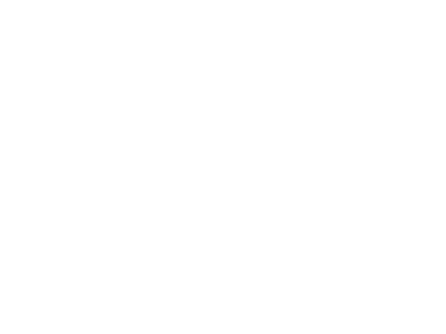

In [4]:
fileName_load = 'stat.npy'
stat = np.load(f'{PATH_load_dir_statFile}{fileName_load}', allow_pickle=True)
print('stat file loaded')

fileName_load = 'iscell.npy'
iscell = np.load(f'{PATH_load_dir_statFile}{fileName_load}', allow_pickle=True)
print('iscell file loaded')

num_ROI = stat.shape[0]
print(f'Number of ROIs: {num_ROI}')

height = 512
width = 1024
spatial_footprints_centered = np.zeros((num_ROI, 241,241))
for i in range(num_ROI):
    spatial_footprints_centered[i , stat[i]['ypix'] - np.int16(stat[i]['med'][0]) + 120, stat[i]['xpix'] - np.int16(stat[i]['med'][1]) + 120] = stat[i]['lam'] # this is formatted for coding ease (dim1: y pix) (dim2: x pix) (dim3: ROI#)
spatial_footprints_centered_crop = spatial_footprints_centered[:, 102:138 , 102:138]

%matplotlib notebook
plt.figure()
plt.imshow(np.max(spatial_footprints_centered_crop , axis=0) ** 0.2);
plt.title('spatial_footprints_centered_crop MIP^0.2');

images = spatial_footprints_centered_crop

In [5]:
## lOAD & PREPROCESS stat.npy file
## outputs: 'images' (input into CNN)

# dir_load = '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\round 4 experiments\\mouse 6.28\\20200815\\suite2p\\plane0\\'
fileName_load = 'stat.npy'

# PATH_absolute = pathlib.Path('.').absolute()
# PATH_load_dir_statFile = f'{PATH_absolute}/'
# PATH_load_dir_statFile = '/media/rich/Home_Linux_partition/GoogleDrive_ocaml_cache/Research/Sabatini Lab Stuff - working/Code/PYTHON/ROI_Classifiers/test data_ mouse2_5 _ 20200308/'
# PATH_load_dir_statFile = '/media/rich/Home_Linux_partition/GoogleDrive_ocaml_cache/Research/Sabatini Lab Stuff - working/Code/PYTHON/ROI_Classifiers/label data/mouse 6_28 _ day 20200903/'
PATH_load_dir_statFile = '/media/rich/Home_Linux_partition/GoogleDrive_ocaml_cache/Research/Sabatini Lab Stuff - working/Code/PYTHON/ROI_Classifiers/label data/mouse6_28 _ day20200815/'
print(PATH_load_dir_statFile)

/media/rich/Home_Linux_partition/GoogleDrive_ocaml_cache/Research/Sabatini Lab Stuff - working/Code/PYTHON/ROI_Classifiers/label data/mouse6_28 _ day20200815/


In [6]:
## Define model architecture
## DO NOT CHANGE ANYTHING HERE!!!
## This architecture is linked to the .pth parameters file

import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, Sigmoid, SELU, GELU, PReLU, Softplus, Softmax2d
from torch.optim import Adam, SGD

In [7]:
dropout_prob = 0.3
momentum_val = 0.9

class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            BatchNorm2d(1, momentum=momentum_val),
            Conv2d(1, 16, kernel_size=4, stride=1, padding=1),
            BatchNorm2d(16, momentum=momentum_val),
            ReLU(),
#             Dropout(dropout_prob*0.1),
            MaxPool2d(kernel_size=2, stride=2),
            
           # Defining a 2D convolution layer
            Conv2d(16, 16, kernel_size=4, stride=1, padding=1),
            BatchNorm2d(16, momentum=momentum_val),
            ReLU(),
#             Dropout(dropout_prob*0.1),
            MaxPool2d(kernel_size=2, stride=2),
            
# #             # Defining another 2D convolution layer
#             Conv2d(16, 32, kernel_size=4, stride=1, padding=2),
# #             BatchNorm2d(64, momentum=momentum_val),
#             ReLU(),
# #             Dropout(dropout_prob*0.1),
# #             Softmax2d(),
#             MaxPool2d(kernel_size=2, stride=2),
            
# #             # Defining another 2D convolution layer
#             Conv2d(64, 64, kernel_size=4, stride=1, padding=2),
# #             BatchNorm2d(16, momentum=momentum_val),
#             SELU(),
# #             Dropout(dropout_prob*0.1),
# #             Softmax2d(),
#             MaxPool2d(kernel_size=2, stride=2),
            
#             # Defining another 2D convolution layer
#             Conv2d(256, 1024, kernel_size=4, stride=1, padding=4),
# #             BatchNorm2d(16, momentum=momentum_val),
#             ReLU(),
# #             Dropout(dropout_prob*0.1),
# #             Softmax2d(),
#             MaxPool2d(kernel_size=2, stride=2),
            
#             # Defining another 2D convolution layer
#             Conv2d(1024, 32, kernel_size=4, stride=1, padding=4),
# #             BatchNorm2d(16, momentum=momentum_val),
#             ReLU(),
# #             Dropout(dropout_prob*0.1),
# #             Softmax2d(),
#             MaxPool2d(kernel_size=2, stride=2),
            
#             # Defining another 2D convolution layer
#             Conv2d(64, 16, kernel_size=4, stride=1, padding=2),
# #             BatchNorm2d(16, momentum=momentum_val),
#             SELU(),
# #             Dropout(dropout_prob*0.1),
# #             Softmax2d(),
#             MaxPool2d(kernel_size=2, stride=2),

        )

        self.linear_layers = Sequential(
            
#             Linear(1296, 512),
# #             Dropout(dropout_prob * 1),
#             ReLU(),
# #             Softmax(dim=0),
# #             Sigmoid(),
            
            
#             Linear(1024, 128),
#             Dropout(dropout_prob * 1),
#             ReLU(),

            Linear(1024, 6),
# #             ReLU(),
# #             Softmax(dim=0),
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
#         if epoch%1000==0:
#             print(epoch)
#             print(x.shape)
# #         x = x.view(x.size(0), -1)
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))
#         if epoch%1000==0:
#             print(epoch)
#             print(x.shape)
        x = self.linear_layers(x)
        return x 

In [8]:
#### ENTER FILENAME + PATH OF NETWORK .pth FILE

PATH_load_name_netParams = 'Net_trainedOnAug_20200928_trainingSet_mouse628_20200903and20200815.pth'
# PATH_load_dir_netParams = 'G:/My Drive/Research/Sabatini Lab Stuff - working/Code/PYTHON/ROI_Classifiers/'
PATH_absolute = pathlib.Path('.').absolute()
PATH_load_dir_netParams = f'{PATH_absolute}/'
print(f'{PATH_load_dir_netParams}{PATH_load_name_netParams}')

model = Net()
model.load_state_dict(torch.load(f'{PATH_load_dir_netParams}{PATH_load_name_netParams}'))
model.eval()

/media/rich/Home_Linux_partition/GoogleDrive_ocaml_cache/Research/Sabatini Lab Stuff - working/Code/PYTHON/ROI_Classifiers/ROI_Classifier_20200928/Net_trainedOnAug_20200928_trainingSet_mouse628_20200903and20200815.pth


Net(
  (cnn_layers): Sequential(
    (0): BatchNorm2d(1, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (1): Conv2d(1, 16, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 16, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=1024, out_features=6, bias=True)
  )
)

In [9]:
input_x = torch.tensor(images[:,None,:,:]).type('torch.FloatTensor')

output = model(input_x).cpu().detach().numpy()
softmax = np.exp(output)
prob = softmax
predictions = np.argmax(list(prob), axis=1)


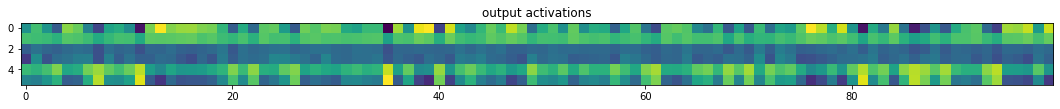

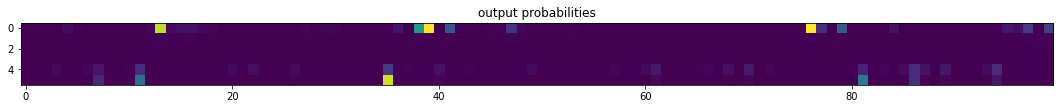

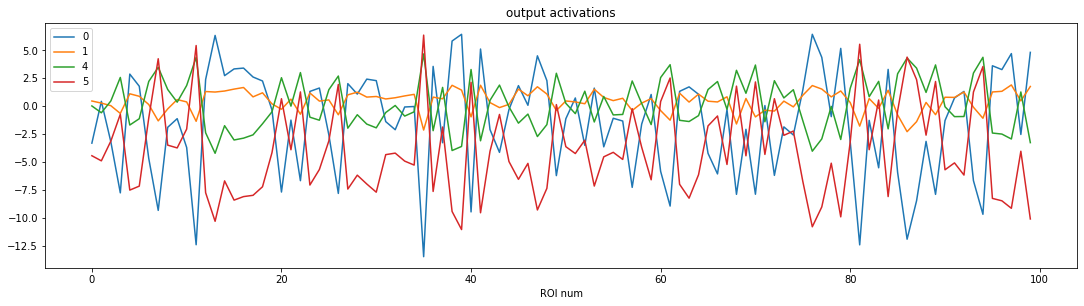

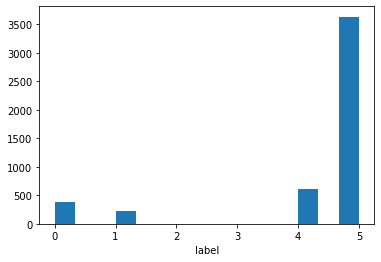

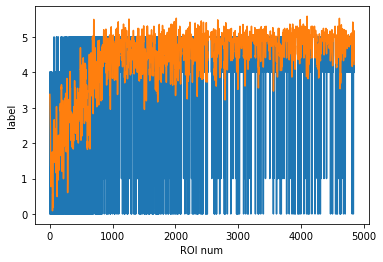

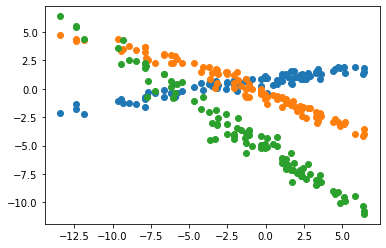

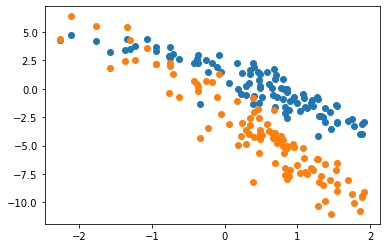

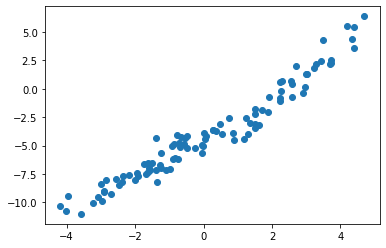

In [10]:
## Show some of the results
%matplotlib inline

ind_to_plot =np.arange(100,200)

fig_output = plt.figure();
plt.imshow(output[ind_to_plot,:].T);
plt.title('output activations');
fig_output.set_size_inches(18.5, 10.5)

fig_prob = plt.figure();
plt.imshow(prob[ind_to_plot,:].T);
plt.title('output probabilities');
fig_prob.set_size_inches(18.5, 10.5)

fig_prob_lines = plt.figure();
plt.plot(output[ind_to_plot, :][:,np.array([0,1,4,5])])
plt.title('output activations');
plt.xlabel('ROI num')
fig_prob_lines.set_size_inches(18.5, 4.5)
plt.legend(('0','1','4','5'))

fig_predHist = plt.figure();
plt.hist(predictions , 15);
plt.xlabel('label')

fig_predLines = plt.figure();
plt.plot(predictions);
plt.plot(scipy.signal.savgol_filter(predictions,19,3));
plt.xlabel('ROI num')
plt.ylabel('label')

fig_scatterGroups0 = plt.figure();
plt.scatter(output[ind_to_plot , np.array([0])] , output[ind_to_plot , np.array([1])])
plt.scatter(output[ind_to_plot , np.array([0])] , output[ind_to_plot , np.array([4])])
plt.scatter(output[ind_to_plot , np.array([0])] , output[ind_to_plot , np.array([5])])
fig_scatterGroups1 = plt.figure();
plt.scatter(output[ind_to_plot , np.array([1])] , output[ind_to_plot , np.array([4])])
plt.scatter(output[ind_to_plot , np.array([1])] , output[ind_to_plot , np.array([5])])
fig_scatterGroups4 = plt.figure();
plt.scatter(output[ind_to_plot , np.array([4])] , output[ind_to_plot , np.array([5])])

<IPython.core.display.Javascript object>


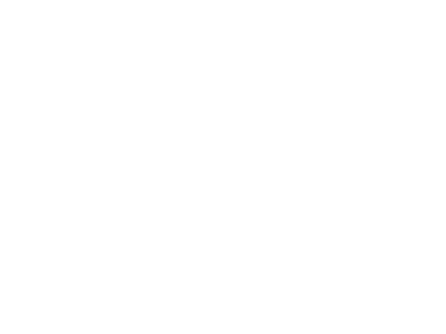

KeyboardInterrupt: Interrupted by user

In [11]:
## UNCOMMENT to Look at individual cells


## Press ENTER to advance. Press 9 to exit


class_to_test = 0


%matplotlib qt
plt.figure()
plt.pause(0.5) 
input_val = 0
iter_start = 1900
while np.int8(input_val) < 7:
    for ii in np.where(predictions ==class_to_test)[0]:
        if ii >= iter_start:
            plt.imshow(images[ii, : , :])
            plt.title(ii)
            plt.show(block=False)
            plt.pause(0.05) 
            input_val = input()
            if not input_val:
                continue
            if np.int8(input_val) >=7:
                break
            plt.pause(0.05) 

## Save data as a .mat file (for CellReg or whatever)

# PATH_save_dir = 'G:/My Drive/Research/Sabatini Lab Stuff - working/Code/PYTHON/ROI_Classifiers/'
PATH_absolute = pathlib.Path('.').absolute()
PATH_save_dir = f'{PATH_absolute}/'
PATH_save_name = 'outputs_CNN.mat'

outputs_CNN = dict()
outputs_CNN = {
    'CNN_outputs_raw': output ,
    'CNN_probabilities': prob ,
    'CNN_predictions': predictions}

scipy.io.savemat(f'{PATH_save_dir}{PATH_save_name}' , outputs_CNN)

Compare S2p classifier with my own
(From decoding_test_script)

In [57]:
import sklearn as sk
from sklearn import cluster

<IPython.core.display.Javascript object>


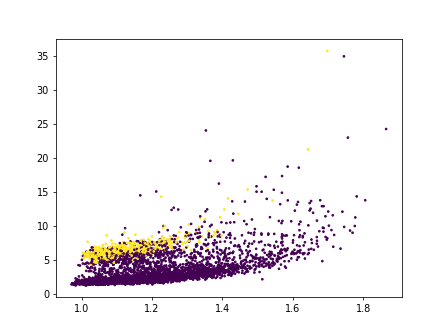

In [58]:
# Define ROIs as cells or not
# I am finding that the intersection of a k-means on some stat params and the built in classifier probability is pretty good
num_cells = stat.shape[0]
all_stat_keys = stat[1].keys()
all_stat_keys = np.array([*all_stat_keys])

# stat_keys_toUse = [3,4,5,6,8,9,10,11,13,14]
# stat_keys_toUse = [8,10]
stat_keys_toUse = [6,8,10,11, 13]

data_for_classifier = np.zeros((num_cells , len(stat_keys_toUse)))

for ii,val in enumerate(all_stat_keys[stat_keys_toUse]):
#     print(val)
# #     print(ii)
#     print('test')
#     print(stat[0][val])
    data_for_classifier[:,ii] = [stat[ii][val] for ii in range(len(stat))]
data_for_classifier = np.concatenate((data_for_classifier , output) , axis = 1)

data_for_classifier = np.hstack((data_for_classifier, iscell[:,1].reshape((iscell.shape[0],1))))

cluster_IDs = sk.cluster.KMeans(n_clusters=2, random_state=2637).fit(data_for_classifier).labels_

%matplotlib notebook
h = plt.figure()
# plt.scatter(data_for_classifier[:,7], data_for_classifier[:,9], s=2, c=cluster_IDs)
# plt.scatter([stat[ii]['aspect_ratio'] for ii in range(num_cells)], [stat[ii]['radius'] for ii in range(num_cells)], s=3, c=cluster_IDs);
# plt.scatter([stat[ii]['aspect_ratio'] for ii in range(num_cells)], [stat[ii]['radius'] for ii in range(num_cells)], s=3, c=iscell[:,1] > 0.1);

is_cell_new = np.array(iscell[:,1] > 0.05) *  np.array(cluster_IDs == 0)
is_cleanROI_forPopulationAnalysis = np.array(iscell[:,1] > 0.05)

plt.scatter([stat[ii]['aspect_ratio'] for ii in range(num_cells)], 
            [stat[ii]['radius'] for ii in range(num_cells)], s=3, 
            c= (predictions<3));
#             c= is_cell_new==0);
#             c=cluster_IDs);
#             c=iscell[:,1] > 0.2);

<IPython.core.display.Javascript object>


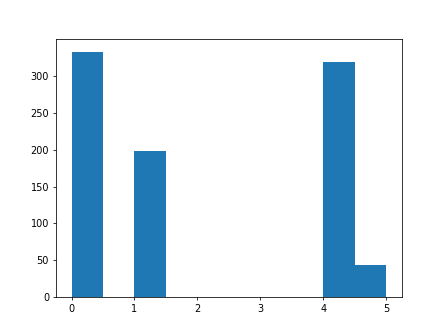

In [62]:
plt.figure()
# test = np.array([stat[ii]['radius'] for ii in range(stat.shape[0])])
test = iscell
plt.hist(predictions[(test[:,1]>0.8)]);

Convert file to CellReg .mat file and format

In [115]:
# st = np.load(STATS_FILENAME)
n_rois = stat.shape[0]
# Image size in pixels
# What if motion correction changed the image size? 
height = 512
width = 1024
spatial_footprints = np.zeros((n_rois, height, width))
for i in range(n_rois):
    spatial_footprints[i, stat[i]['ypix'], stat[i]['xpix']] = stat[i]['lam']

ROI_idx_toUse = np.where(predictions ==0)[0]
spatial_footprints_cellsOnly = np.zeros((len(ROI_idx_toUse) , height, width))
for i,val in enumerate(ROI_idx_toUse):
#     print(i)
    spatial_footprints_cellsOnly[i, stat[val]['ypix'], stat[val]['xpix']] = stat[val]['lam']


<IPython.core.display.Javascript object>


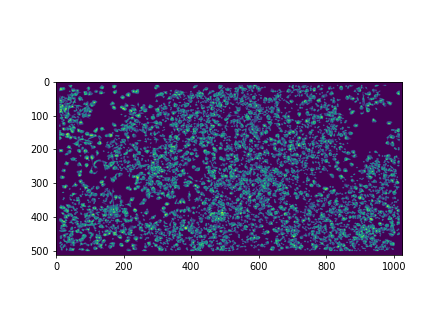

In [116]:
plt.figure()
plt.imshow(np.max((spatial_footprints.transpose(1,2,0) / np.max(np.max(spatial_footprints,axis=2),axis=1) ), axis=2))

<IPython.core.display.Javascript object>


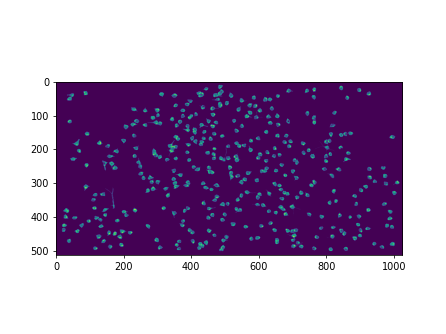

In [118]:
plt.figure()
plt.imshow(np.max((spatial_footprints_cellsOnly.transpose(1,2,0) / np.max(np.max(spatial_footprints_cellsOnly,axis=2),axis=1) ), axis=2))

In [ ]:
## Save data as a .mat file (for CellReg or whatever)

# PATH_save_dir = 'G:/My Drive/Research/Sabatini Lab Stuff - working/Code/PYTHON/ROI_Classifiers/'
PATH_absolute = pathlib.Path('.').absolute()
PATH_save_dir = f'{PATH_absolute}/'
PATH_save_name = 'outputs_CNN.mat'

print(f'Save PATH:  {PATH_save_dir}{PATH_save_name}')


outputs_CNN = dict()
outputs_CNN = {
    'CNN_outputs_raw': output ,
    'CNN_probabilities': prob ,
    'CNN_predictions': predictions,
    'spatial_footprints': spatial_footprints,
}

scipy.io.savemat(f'{PATH_save_dir}{PATH_save_name}' , outputs_CNN)

Save PATH:  /media/rich/Home_Linux_partition/GoogleDrive_ocaml_cache/Research/Sabatini Lab Stuff - working/Code/PYTHON/ROI_Classifiers/ROI_Classifier_20200928/outputs_CNN.mat


EVERYTHING BELOW FOR POSTHOC RELABELING

In [ ]:
labels_posthoc = np.zeros(num_ROI)

In [ ]:
# %matplotlib qt
plt.figure()
# plt.imshow(spatial_footprints_crop[: , : , 0])
plt.pause(0.5) 
input_val = 0
iter_start = 50
num_ROI = images.shape[0]

while np.int8(input_val) < 7:
    for ii in np.where(labels_posthoc_filledIn ==5)[0]:
        if ii >= iter_start:
#             print(ii)

            plt.imshow(images[ii, : , :])
            plt.title(ii)
            plt.show(block=False)
            plt.pause(0.25) 

            input_val = input()

            if not input_val:
                continue
            if np.int8(input_val) >=7:
                break
            if input_val:
                labels_posthoc[ii] = np.int8(input_val)
            plt.pause(0.25) 
#             print(f'Num labeled: {ii}')
    

In [ ]:
# %matplotlib inline
plt.figure()
plt.plot(labels_posthoc)
plt.figure()
plt.hist(labels_posthoc[labels_posthoc > 0]);

In [ ]:
import copy
labels_posthoc_indOfCorrected_bool = labels_posthoc > 0
# labels_posthoc_filledIn = copy.deepcopy(predictions)
labels_posthoc_filledIn[labels_posthoc_indOfCorrected_bool] = labels_posthoc[labels_posthoc_indOfCorrected_bool] -1
plt.figure()
plt.plot(labels_posthoc_filledIn)
plt.figure()
plt.hist(labels_posthoc_filledIn,20);

In [ ]:
np.save('labels_posthoc_all_NEW22222.npy',labels_posthoc_filledIn)
# np.save('labels_posthoc.npy',labels_posthoc)